In [112]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import wandb
from torchvision.io import read_image

from wandb_utils import *

api = wandb.Api()
run = example_train_run(api)
run = RunWrapper(run)

manager = RunDataManager(Path('../run_data'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
run_1 = RunWrapper(api.run('romeu/NeRF2D/qyxltox2'))
run_2 = RunWrapper(api.run('romeu/NeRF2D/5x9fjp84'))

runs = [run_1, run_2]

In [120]:


from nerf2d_dataset import NeRF2D_Datamodule

data_art = first_used_artifact_of_type(run_1.run, 'dataset')
data_art_folder = Path(data_art.download())

model_art = [a for a in run_1.run.logged_artifacts() if a.type == 'model'][0]

ckpt = get_ckpt(model_art)
dm = NeRF2D_Datamodule.load_from_checkpoint(ckpt, folder=data_art_folder)
dm.hparams

wandb:   406 of 406 files downloaded.  
wandb:   1 of 1 files downloaded.  


"batch_size":       1000
"camera_subset":    False
"camera_subset_n":  5
"image_resolution": 100
"n_train_images":   5000
"t_far":            6

In [82]:
files = run_1.get_files_by_label('val_renders')

100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


bunny:v0


100%|██████████| 1/1 [00:00<00:00, 798.76it/s]


bunny:v0


100%|██████████| 1/1 [00:00<00:00, 828.10it/s]


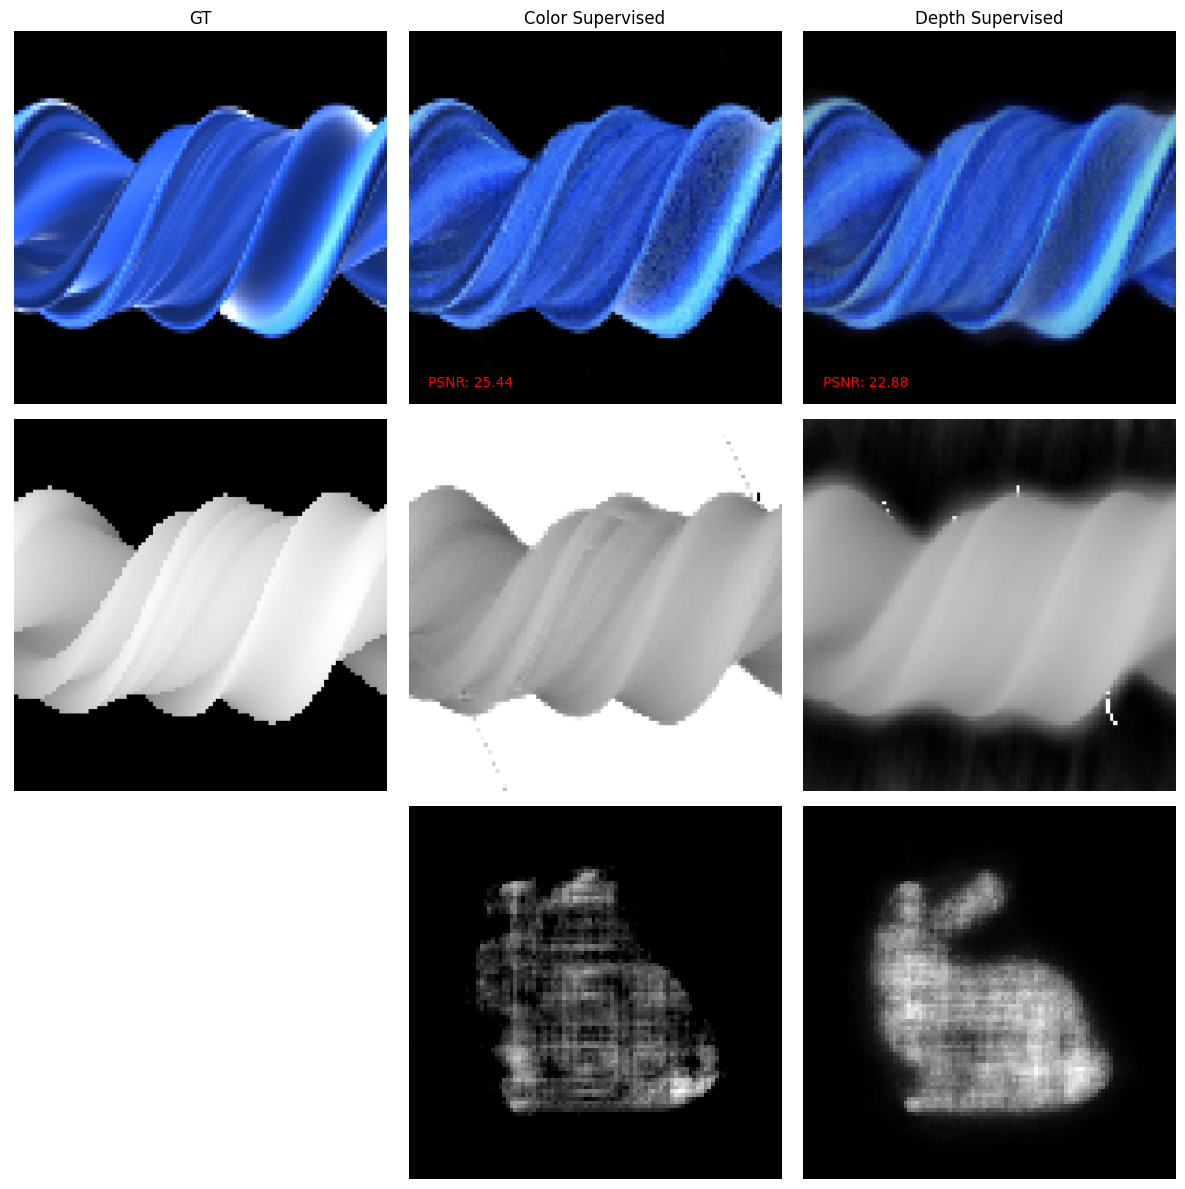

In [97]:
from torchvision.io import ImageReadMode

def compare_runs(
        runs,
        with_density=True,
        with_depth=True,
        with_gt=True,
        with_renders=True,
        depth_cmap='gray',
        show_psnr=True,
        fig_scale=4,
        title_fun=lambda run: None
):
    n_rows = (1 if with_renders else 0) + (1 if with_depth else 0) + (1 if with_density else 0)
    n_cols = len(runs) + (1 if with_gt else 0)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(fig_scale * n_cols, fig_scale * n_rows))
    axs = axs.reshape(n_rows, n_cols)

    for ax in axs.flatten():
        ax.axis('off')

    if with_gt:
        # read ground_truth render
        axs[0, 0].set_title('GT')

        row = -1
        if with_renders:
            row += 1
            gt_render = read_image(manager.download_run_files_by_label(run_1, 'val_renders_gt')[0])
            axs[row, 0].imshow(gt_render.permute(1, 2, 0))

        if with_depth:
            row += 1
            gt_depth = read_image(manager.download_run_files_by_label(run_1, 'val_depth_gt')[0], ImageReadMode.GRAY)
            axs[row, 0].imshow(gt_depth[0], cmap=depth_cmap)

    for i, run in enumerate(runs):

        data_art = first_used_artifact_of_type(run.run, 'dataset')

        gt_offset = 1 if with_gt else 0
        row = -1

        # set title
        title = title_fun(run)
        axs[0, i + gt_offset].set_title(title)

        if with_renders:
            row += 1
            render = read_image(manager.download_run_files_by_label(run, 'val_renders')[-1])
            ax = axs[row, i + gt_offset]
            ax.imshow(render.permute(1, 2, 0))

            if show_psnr:
                psnr = run.run.summary["val_psnr"]
                H = render[0].shape[0]
                W = render[0].shape[1]
                ax.text(W * 0.05, H * 0.95, f'PSNR: {psnr:.2f}', color='red', fontsize=10)

        if with_depth:
            row += 1
            depth = read_image(manager.download_last_run_file_by_label(run, 'val_depths')[0])
            ax = axs[row, i + gt_offset]
            ax.imshow(depth[0], cmap=depth_cmap)

        if with_density:
            row += 1
            density = read_image(manager.download_last_run_file_by_label(run, 'density')[0])
            ax = axs[row, i + gt_offset]
            ax.imshow(density[0], cmap=depth_cmap)

    plt.tight_layout()

def title_fun(run):
    return 'Depth Supervised' if run.run.config["use_depth_supervision"] else 'Color Supervised'

compare_runs(
    runs,
    with_gt=True,
    with_renders=True,
    with_depth=True,
    with_density=True,
    fig_scale=4,
    title_fun=title_fun
)